# Post-alignment QC with samtools flagstat, FastQC, PICARD's CollectRnaSeqMetrics, RSeQC, MultiQC

| Tool                            | Type             | Key Metrics Provided                                                                                             | Input Type       | Strengths                                                                  | Limitations                                                                             |
| ------------------------------- | ---------------- | ---------------------------------------------------------------------------------------------------------------- | ---------------- | -------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- |
| **samtools flagstat**           | Basic Summary    | - Total reads<br>- Mapped/unmapped<br>- Properly paired<br>- Duplicates<br>- Singletons                          | BAM              | 🔹 Fast & simple<br>🔹 Good for mapping stats                              | ❌ No biological context<br>❌ No insert size or bias metrics                             |
| **FastQC**                      | Per-read QC      | - Sequence quality<br>- GC bias<br>- Overrepresented sequences<br>- Adapter content<br>- Duplication levels      | FASTQ / BAM      | 🔹 Highlights technical issues<br>🔹 Fast and visual                       | ❌ Doesn’t interpret alignments well<br>❌ Limited post-BAM metrics                       |
| **Picard CollectRnaSeqMetrics** | RNA-seq specific | - % Exonic, Intronic, Intergenic<br>- 5’/3’ bias<br>- rRNA contamination<br>- Strand specificity                 | BAM + annotation | 🔹 Rich RNA-seq insights<br>🔹 Used in publications                        | ❌ Requires reference annotation<br>❌ Slower                                             |
| **RSeQC**                       | RNA-seq suite    | - Read distribution across genomic features<br>- Junction saturation<br>- Gene body coverage<br>- Insertion bias | BAM + BED/GTF    | 🔹 Excellent for RNA-seq diagnostics<br>🔹 Easy command-line modules       | ❌ Requires GTF or BED<br>❌ Not all modules multiQC-compatible                           |
| **MultiQC**                     | Aggregator       | - Collates results from FastQC, Picard, samtools, STAR, Salmon, RSeQC, etc.                                      | Output files     | 🔹 Unified dashboard<br>🔹 Interactive reports<br>🔹 Works with many tools | ❌ Doesn’t compute QC itself<br>❌ Relies on proper file naming & output from other tools |


## 1. samtools
### a. samtools view

In [2]:
cd $RNA_ALIGN_DIR

In [ ]:
# View the header section of BAM file:
samtools view -H UHR.bam

# View the first 10 alignments in BAM file
samtools view UHR.bam | head
# A more organized way to view the first 2 (or any number of) alignments in BAM file
# DON'T run "less" command on Jupyter Notebook as we can't press "q" to exit
# samtools view UHR.bam | head -n 2 | column -t | less -S # it will open a pop up window (screenshot below), use the left and right arrow key to navigate, when done, press "q" to exit

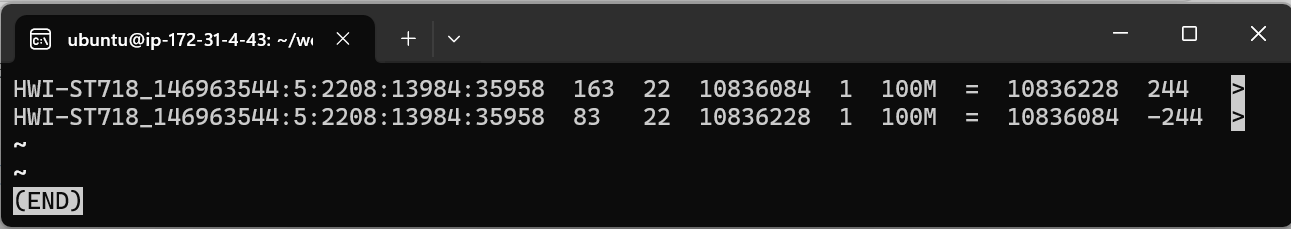

### Try filtering the BAM file to require or exclude certain flags. This can be done with samtools view -f -F options.
- **-f FLAG-bits-set: Include only reads that have all specified FLAG bits set**
- **-F FLAG-bits-set: Exclude reads with any of these FLAG bits set**
- **-f FLAG-bits-set** and **-F FLAG-bits-set** can be used independently or together
- [More info on samtools flags explanation](http://broadinstitute.github.io/picard/explain-flags.html)
- **FLAG-bits-set for alignments that are ‘paired’ and ‘mapped in a proper pair’ is *3***
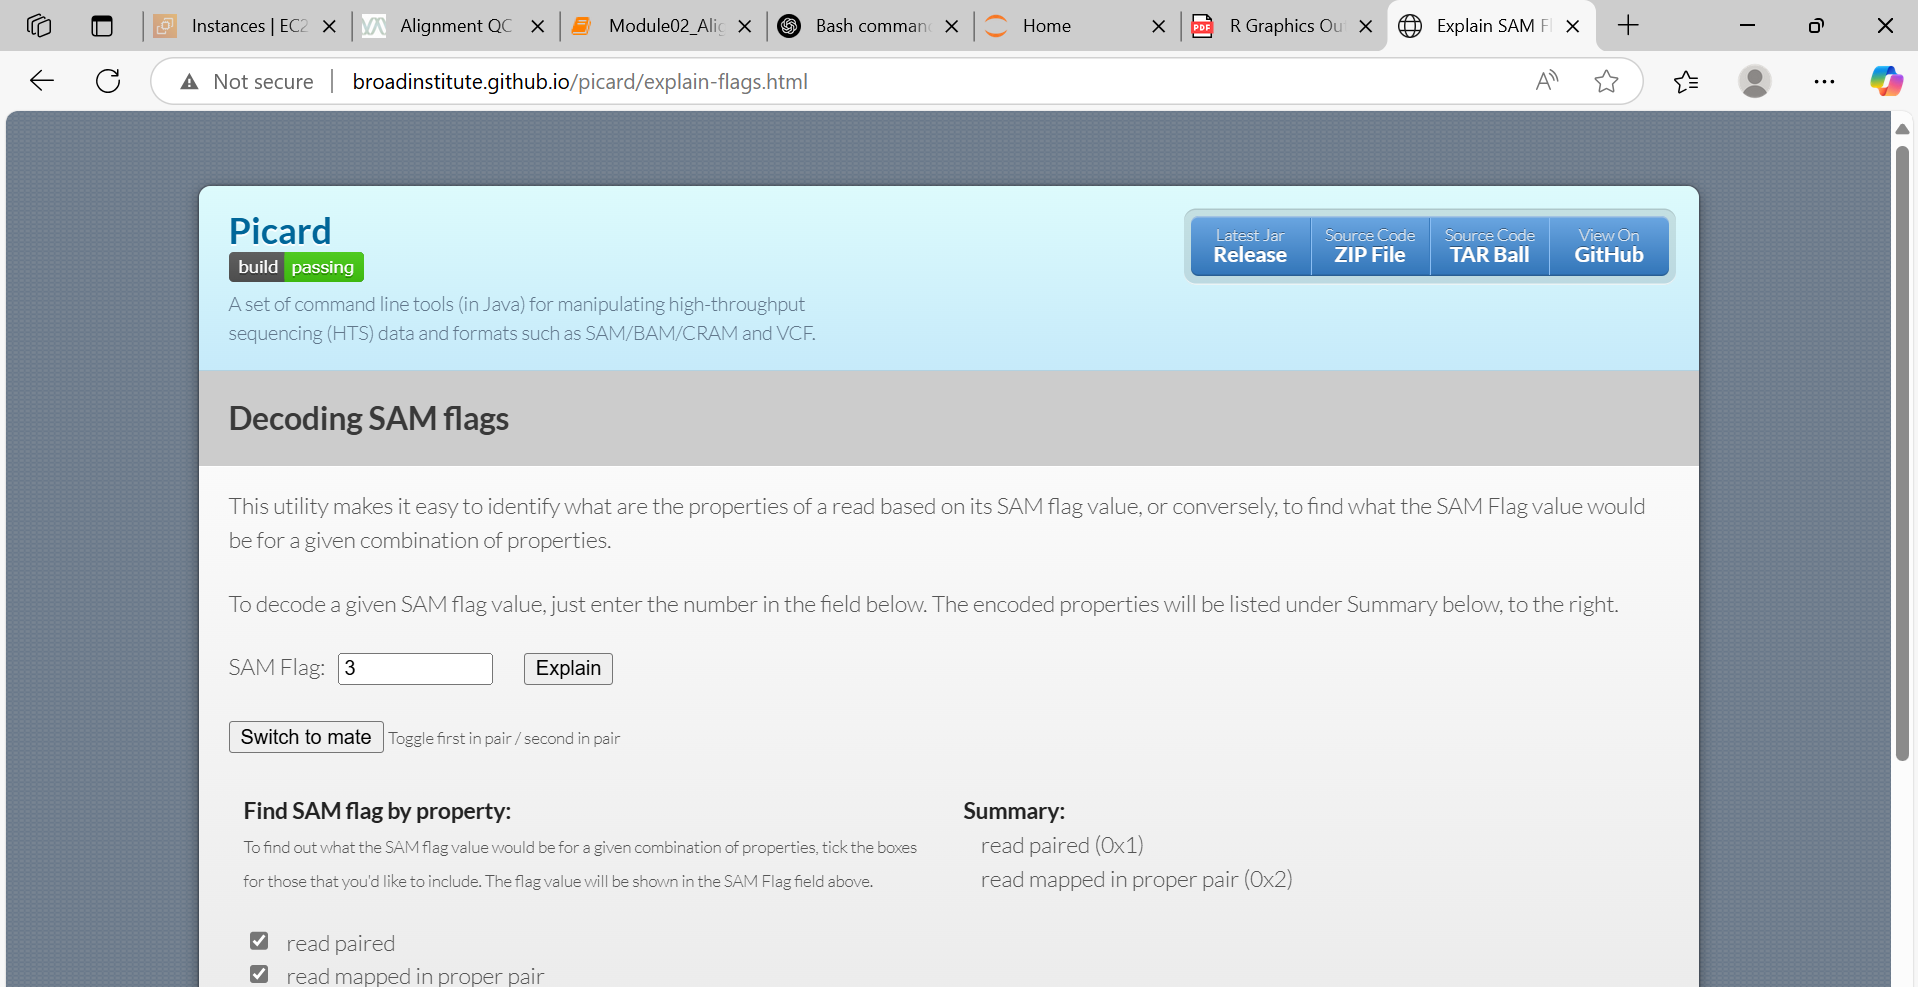

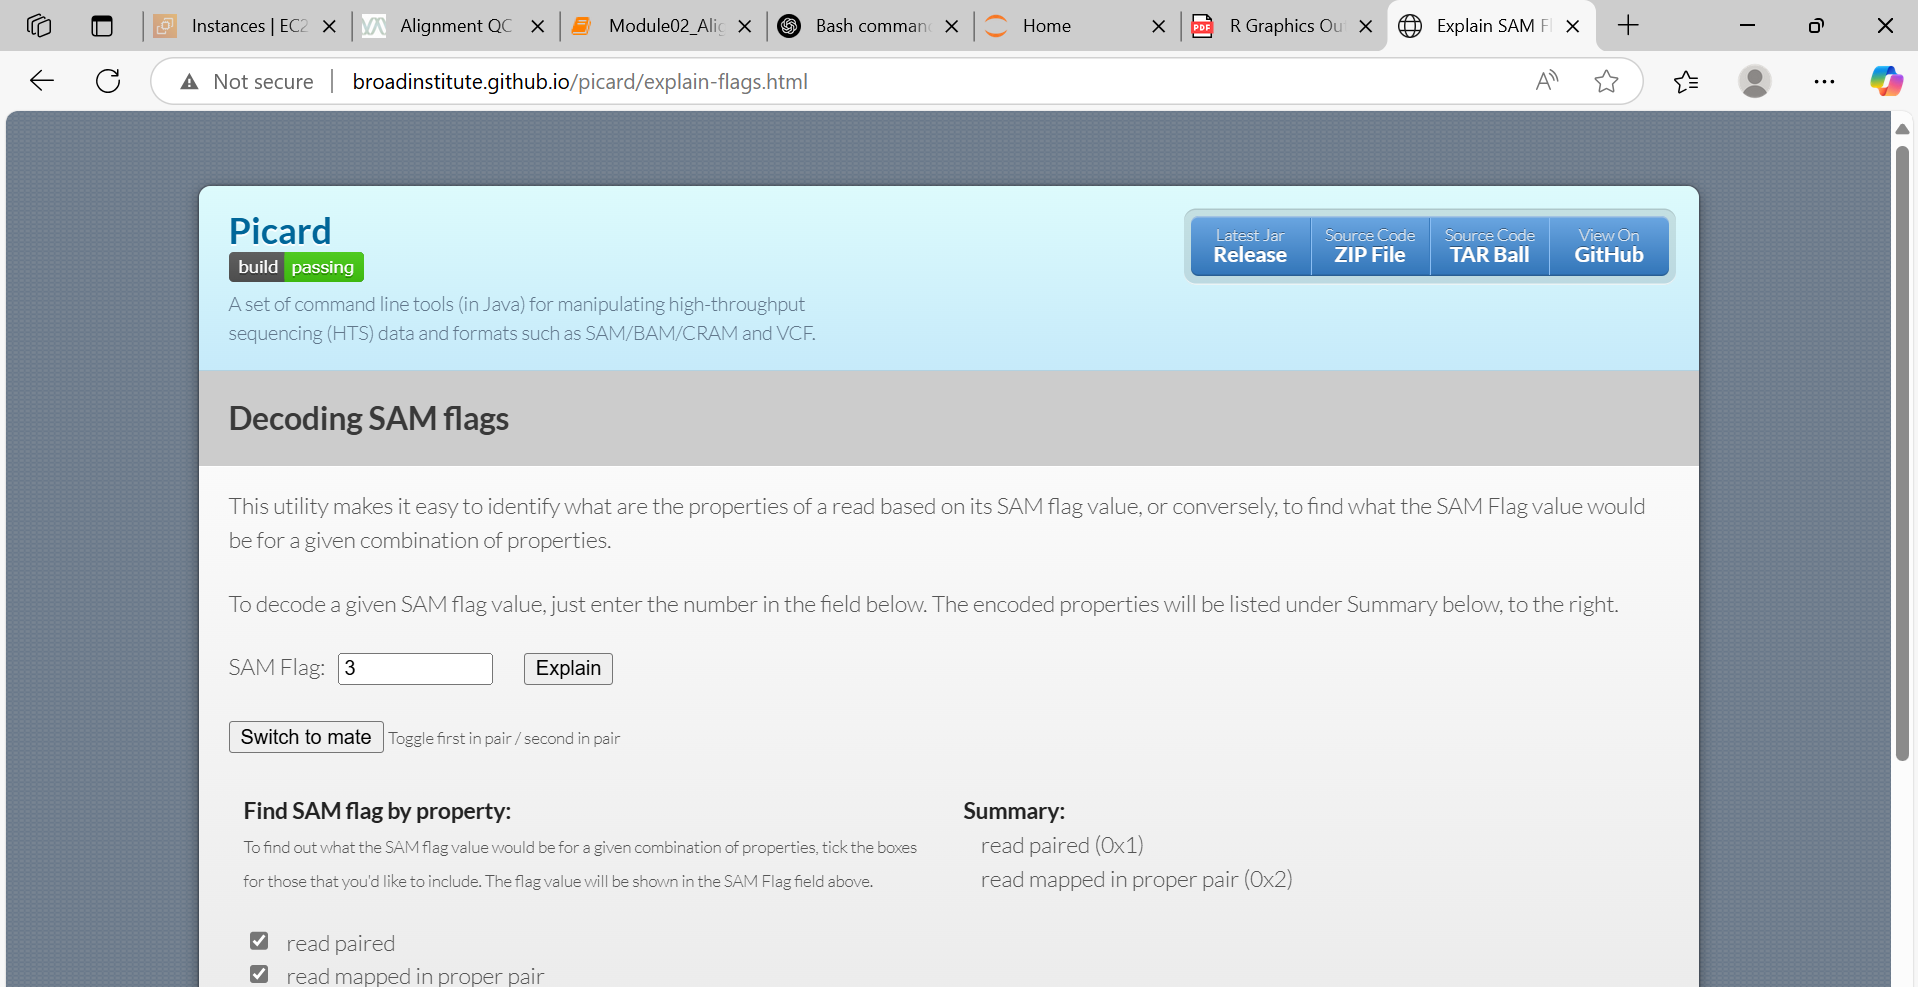

- **FLAG-bits-set for alignments that are ‘unmapped’, the ‘mate is unmapped’, and ‘not primary alignment’ is *268***
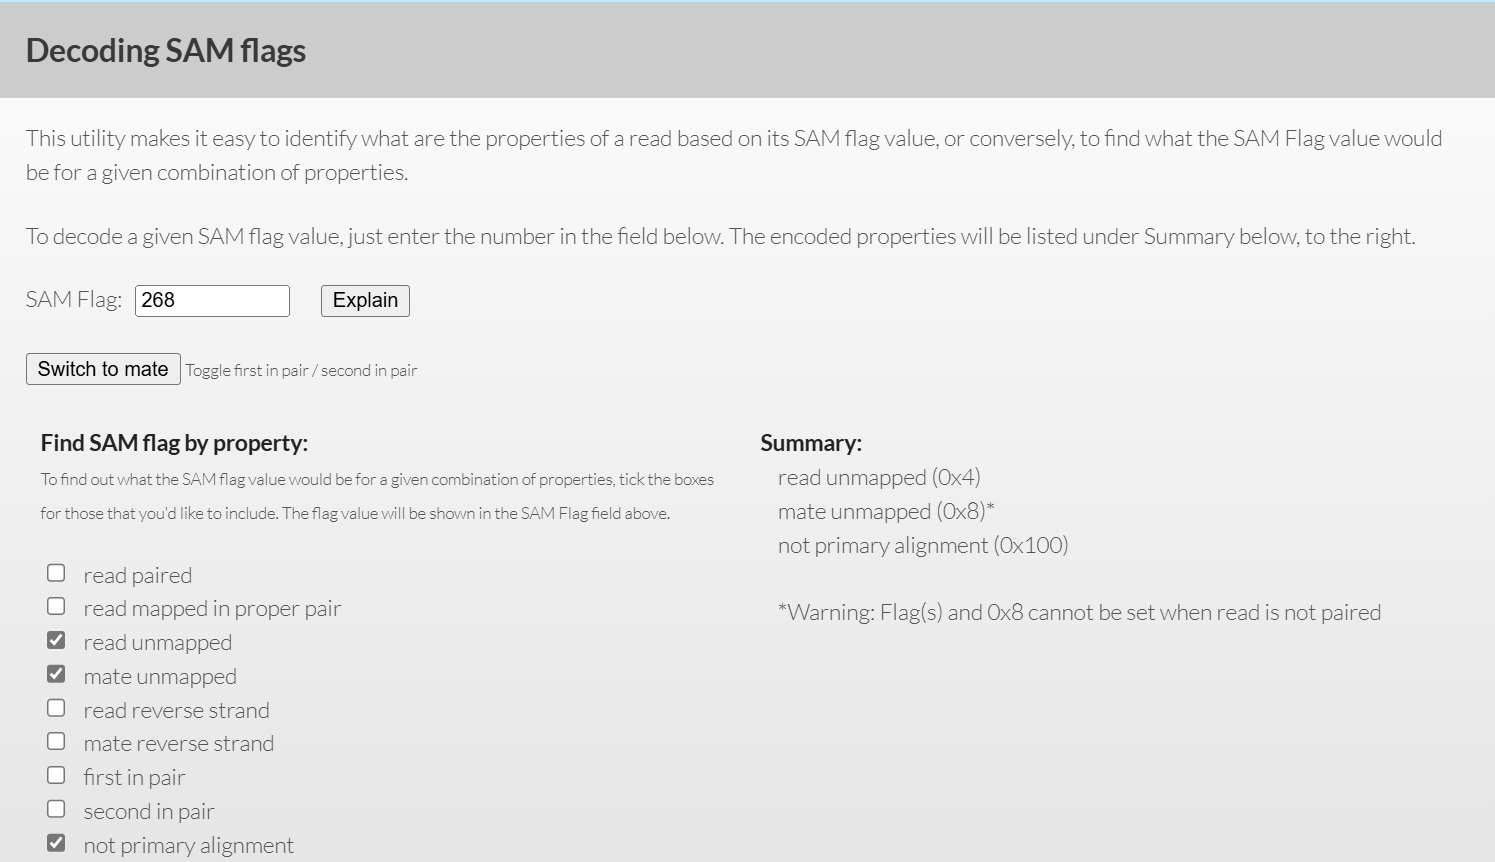

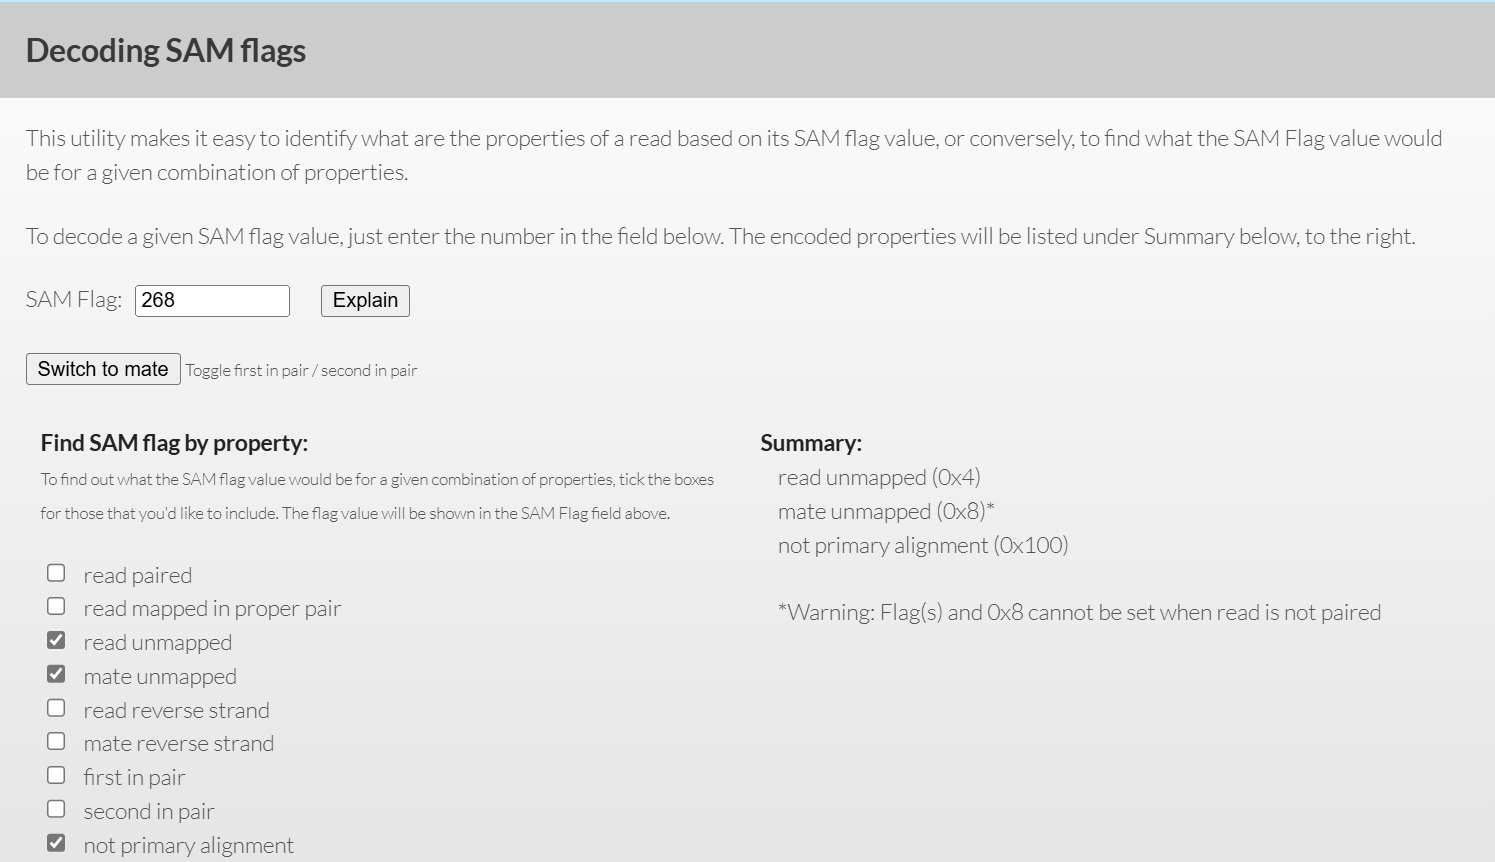

In [3]:
# include alignments are ‘paired’ and ‘mapped in a proper pair’ (=3). 
# while exclude alignments that are ‘unmapped’, the ‘mate is unmapped’, and ‘not primary alignment’ (=268)
samtools view -f 3 -F 268 UHR.bam | wc -l # count how alignments satify -f 3 and -F 268, which is 1143860
samtools view -f 3 -F 268 UHR.bam | head -n 2 # view the first 2 alignments
# samtools view -f 3 -F 268 UHR.bam | head | column -t | less -S

1143860
HWI-ST718_146963544:5:2208:13984:35958	163	22	10836084	1	100M	=	10836228	244	CACAAAGAAGCAAACTGTGTCCTGAACAGTTTTGCAAACTCTGTAGTTGGTAGTATTCTTTTCACACGTCTTTCTTGTCGTTCTTTTTAACAACAGTCAT	CCCFFFDFHHHHHJJIIHGIJJJJIJIIJHGHIIIIIJJIIIGGIIIIIICFGIHIJEIHIIDGIIJJHGIJJIGJIHHHEFBBDEEECCACDDDDA:AD	AS:i:0	ZS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:100	YS:i:-6	YT:Z:CP	RG:Z:UHR_Rep1	XS:A:+	NH:i:2
HWI-ST718_146963544:5:2208:13984:35958	83	22	10836228	1	100M	=	10836084	-244	GTGACATAGTATAGTATCCTTAGTATCCTAACACACAGTAGAGTACCTAAAGTCAGAACTTTTAAGAGAGATACCTGTAAATTTGGACATTACATCAGAT	EDFCDDDEEHFHEHHIGIJJIHEHHIJIHHGIIJGIIIJJIHIHGFJHGIICGIGIJIIHIFJJJJJJIHHFBJJIJIJJJJJIJIJGHHHHFFFFF@CC	AS:i:-6	ZS:i:-6	XN:i:0	XM:i:1	XO:i:0	XG:i:0	NM:i:1	MD:Z:86G13	YS:i:0	YT:Z:CP	RG:Z:UHR_Rep1	XS:A:+	NH:i:2


In [4]:
# Now require that the alignments be only for ‘PCR or optical duplicate’. How many reads meet this criteria?
samtools view -f 1024 UHR.bam | wc -l

0


In [5]:
# Another way to see how many PCR or optical duplicates are in BAM file:
samtools flagstat UHR.bam

1174955 + 0 in total (QC-passed reads + QC-failed reads)
1150414 + 0 primary
24541 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
1173743 + 0 mapped (99.90% : N/A)
1149202 + 0 primary mapped (99.89% : N/A)
1150414 + 0 paired in sequencing
575207 + 0 read1
575207 + 0 read2
1143860 + 0 properly paired (99.43% : N/A)
1148598 + 0 with itself and mate mapped
604 + 0 singletons (0.05% : N/A)
6 + 0 with mate mapped to a different chr
6 + 0 with mate mapped to a different chr (mapQ>=5)


### Why 0 duplicate is detected?
**-f 1024** is set when an alignment has been marked as a duplicate, typically by tools like:
- samtools markdup
- Picard's MarkDuplicates

No alignments (0) in UHR.bam file are currently marked as duplicates. Either:
- There truly were no duplicates detected in your sequencing data, or
- No duplicate marking step has been run yet.

**To check if dyplicate marking step has been run**, run the **grep PG** command below and look for entries like:
- @PG	ID=markdup	PN=samtools ...
- Or: @PG	ID=MarkDuplicates	PN=picard ...

If there’s no mention of such tools, it’s safe to say: No duplicate marking step has been run yet

In [6]:
samtools view -H UHR.bam | grep PG

@PG	ID:hisat2	PN:hisat2	VN:2.2.1	CL:"/home/ubuntu/bin/hisat2-2.2.1/hisat2-align-s --wrapper basic-0 -p 4 --rg-id=UHR_Rep1 --rg SM:UHR --rg LB:UHR_Rep1_ERCC-Mix1 --rg PL:ILLUMINA --rg PU:CXX1234-ACTGAC.1 -x /home/ubuntu/workspace/rnaseq/refs/chr22_with_ERCC92 --dta --rna-strandness RF -S ./UHR_Rep1.sam --read-lengths 100 -1 /tmp/36026.inpipe1 -2 /tmp/36026.inpipe2"
@PG	ID:hisat2.1	PN:hisat2	VN:2.2.1	CL:"/home/ubuntu/bin/hisat2-2.2.1/hisat2-align-s --wrapper basic-0 -p 4 --rg-id=UHR_Rep2 --rg SM:UHR --rg LB:UHR_Rep2_ERCC-Mix1 --rg PL:ILLUMINA --rg PU:CXX1234-TGACAC.1 -x /home/ubuntu/workspace/rnaseq/refs/chr22_with_ERCC92 --dta --rna-strandness RF -S ./UHR_Rep2.sam --read-lengths 100 -1 /tmp/36043.inpipe1 -2 /tmp/36043.inpipe2"
@PG	ID:hisat2.2	PN:hisat2	VN:2.2.1	CL:"/home/ubuntu/bin/hisat2-2.2.1/hisat2-align-s --wrapper basic-0 -p 4 --rg-id=UHR_Rep3 --rg SM:UHR --rg LB:UHR_Rep3_ERCC-Mix1 --rg PL:ILLUMINA --rg PU:CXX1234-CTGACA.1 -x /home/ubuntu/workspace/rnaseq/refs/chr22_with_ERCC92 --d

### So 0 duplicate is detected because no marking step has been run.

### b. samtools flagstat
Use samtools flagstat to get a basic summary of an alignment. What percent of reads are mapped?

In [ ]:
# Useful trick: Combine 2 commands in sequel in 1 line:
cd $RNA_ALIGN_DIR && mkdir -p flagstat

# Note that we run a samtools flagstat command for all files ending in *Rep*.bam using the following construct:
## find ... -exec echo ... \; produces a list of shell commands.
## That list is then piped into sh, which reads those commands from standard input and executes them.
find *Rep*.bam -exec echo samtools flagstat {} \> flagstat/{}.flagstat \; | sh

**You can find alll these flagstat file in http://your-public-IPv4/rnaseq/alignments/hisat2/flagstat/**

In [8]:
# View an example
cat flagstat/UHR_Rep1.bam.flagstat

464150 + 0 in total (QC-passed reads + QC-failed reads)
454784 + 0 primary
9366 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
463640 + 0 mapped (99.89% : N/A)
454274 + 0 primary mapped (99.89% : N/A)
454784 + 0 paired in sequencing
227392 + 0 read1
227392 + 0 read2
452474 + 0 properly paired (99.49% : N/A)
453996 + 0 with itself and mate mapped
278 + 0 singletons (0.06% : N/A)
4 + 0 with mate mapped to a different chr
4 + 0 with mate mapped to a different chr (mapQ>=5)


## 2. FastQC
You can use FastQC to perform basic QC of your BAM file (See [Pre-alignment QC](https://rnabio.org/module-01-inputs/0001/06/01/Pre-alignment_QC/)). This will give you output very similar to when you ran FastQC on your fastq files.

In [9]:
cd $RNA_ALIGN_DIR
fastqc UHR_Rep1.bam UHR_Rep2.bam UHR_Rep3.bam HBR_Rep1.bam HBR_Rep2.bam HBR_Rep3.bam
mkdir fastqc
mv *fastqc.html fastqc/
mv *fastqc.zip fastqc/

Started analysis of UHR_Rep1.bam
Approx 5% complete for UHR_Rep1.bam
Approx 10% complete for UHR_Rep1.bam
Approx 15% complete for UHR_Rep1.bam
Approx 20% complete for UHR_Rep1.bam
Approx 25% complete for UHR_Rep1.bam
Approx 30% complete for UHR_Rep1.bam
Approx 35% complete for UHR_Rep1.bam
Approx 40% complete for UHR_Rep1.bam
Approx 45% complete for UHR_Rep1.bam
Approx 50% complete for UHR_Rep1.bam
Approx 55% complete for UHR_Rep1.bam
Approx 60% complete for UHR_Rep1.bam
Approx 65% complete for UHR_Rep1.bam
Approx 70% complete for UHR_Rep1.bam
Approx 75% complete for UHR_Rep1.bam
Approx 80% complete for UHR_Rep1.bam
Approx 85% complete for UHR_Rep1.bam
Approx 90% complete for UHR_Rep1.bam
Approx 95% complete for UHR_Rep1.bam
Approx 100% complete for UHR_Rep1.bam
Analysis complete for UHR_Rep1.bam
Started analysis of UHR_Rep2.bam
Approx 5% complete for UHR_Rep2.bam
Approx 10% complete for UHR_Rep2.bam
Approx 15% complete for UHR_Rep2.bam
Approx 20% complete for UHR_Rep2.bam
Approx 25% c

#### ❌ MultiQC doesn’t analyze raw BAMs directly
#### ✅ Use samtools, qualimap, picard, etc. to generate stats from BAMs
#### ✅ Then run multiqc on the output folders or text files
We'll get to MultiQC in a bit

## 3. Picard's CollectRnaSeqMetrics
In this section we need to create some additional formats of our reference transcriptome files.
- We filter our transcriptome GTF to one with only ribosomal features, convert it to BED format and then to IntervalList format. This is all done to get the **IntervalList format** needed for **Picard CollectRnaSeqMetrics**
- We will also create a version of our whole transcriptome GTF in the **[RefFlat format](http://genome.ucsc.edu/goldenPath/gbdDescriptionsOld.html#RefFlat)** needed for **Picard CollectRnaSeqMetrics**. To get to the RefFlat format we will convert GTF to **[GenePredExt format](https://genome.ucsc.edu/goldenPath/gbdDescriptionsOld.html#GenePredExt)** and then simplify this to RefFlat.

In [10]:
# Generating the necessary input files for picard CollectRnaSeqMetrics
cd $RNA_HOME/refs

# Create a .dict file for our reference
java -jar $PICARD CreateSequenceDictionary -R chr22_with_ERCC92.fa -O chr22_with_ERCC92.dict

# Create a bed file of the location of ribosomal sequences in our reference (first extract them from the GTF then convert to BED format)
# Note that here we pull all the "rrna" transcripts from the GTF. This is a good strategy for the whole transcriptome ...
# ... but on chr22 there is very little "rrna" content, leading to 0 coverage for all samples, so we are also adding a single protein coding ribosomal gene "RRP7A" (normally we would not do this)

# Note the convert2bed command will convert our GTF to BED format
# "<" is used to feed the GTF file into the tool.  ">2/dev/null" is used to throw away a harmless warning. "1>" is use to save our result to a file

grep --color=none -i -P "rrna|rrp7a" chr22_with_ERCC92.gtf > ref_ribosome.gtf # --color=none is useful for redirecting output to a file, -i = ignore case, -P supports |
convert2bed --input=gtf --output=bed < ref_ribosome.gtf 2>/dev/null 1>ref_ribosome.bed

# Create interval list file for the location of just the ribosomal sequences in our reference
java -jar $PICARD BedToIntervalList -I ref_ribosome.bed -O ref_ribosome.interval_list -SD chr22_with_ERCC92.dict

# Create a genePred file for our whole reference transcriptome
gtfToGenePred -genePredExt chr22_with_ERCC92.gtf chr22_with_ERCC92.genePredExt

# Reformat this genePred file to RefFlat: first add the Ensembl gene ID column to the beginning of the dataframe using "awk", and then subset it down to the first 11 columns using "cut".
cat chr22_with_ERCC92.genePredExt | awk '{print $12"\t"$0}' | cut -d$'\t' -f1-11 > chr22_with_ERCC92.refFlat.txt

# Use the "find" command to run "picard CollectRnaSeqMetrics" on all 6 BAM files. 
# The basic structure of this kind of automation is: find <search pattern> -exec command {} \;
# The "{}" will insert the file found by the "find" command using <search pattern>.  "\;" indicates the end of the command.
cd $RNA_HOME/alignments/hisat2/
mkdir picard
find *Rep*.bam -exec echo java -jar $PICARD CollectRnaSeqMetrics \ 
    I={} \
    O=picard/{}.RNA_Metrics \
    REF_FLAT=$RNA_HOME/refs/chr22_with_ERCC92.refFlat.txt \
    STRAND=SECOND_READ_TRANSCRIPTION_STRAND \
    RIBOSOMAL_INTERVALS=$RNA_HOME/refs/ref_ribosome.interval_list \; | sh

14:07:56.525 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/home/ubuntu/bin/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Sat May 10 14:07:56 EDT 2025] CreateSequenceDictionary --OUTPUT chr22_with_ERCC92.dict --REFERENCE chr22_with_ERCC92.fa --TRUNCATE_NAMES_AT_WHITESPACE true --NUM_SEQUENCES 2147483647 --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREATE_MD5_FILE false --GA4GH_CLIENT_SECRETS client_secrets.json --help false --version false --showHidden false --USE_JDK_DEFLATER false --USE_JDK_INFLATER false
[Sat May 10 14:07:56 EDT 2025] Executing as ubuntu@ip-172-31-4-43 on Linux 6.8.0-1028-aws amd64; OpenJDK 64-Bit Server VM 11.0.27+6-post-Ubuntu-0ubuntu122.04; Deflater: Intel; Inflater: Intel; Provider GCS is not available; Picard version: Version:2.26.4
[Sat May 10 14:07:56 EDT 2025] picard.sam.CreateSequenceDictionary done. Elapsed time: 0.01 minutes.
Runti

#### Warning: Picard's command line syntax is changing
- You can see the warning message when the last command is run: *NOTE: Picard's command line syntax is changing.*
- This warning is more of an informational notice, not something that will break our pipeline (for now)
- You can find the PICARD's output here: http://your-public-IPv4/rnaseq/alignments/hisat2/picard/
- Picard is transitioning from the old syntax (Java-style with -jar and key=value pairs) to a **newer, streamlined syntax** (POSIX-style with **hyphen flags like -I and -O**).
- **Note that since our PICARD is a .jar file (PICARD=/home/ubuntu/bin/picard.jar), we must continue using the java -jar syntax — we can't use the new-style syntax directly with a .jar**
- To see this PICARD path: cd && env | grep PICARD

#### If we did install Picard as a CLI tool (e.g. conda install -c bioconda picard), then we could use the new syntax like this:

In [ ]:
find *Rep*.bam -exec echo picard CollectRnaSeqMetrics \
  -I {} \
  -O picard/{}.RNA_Metrics \
  -REF_FLAT $RNA_HOME/refs/chr22_with_ERCC92.refFlat.txt \
  -STRAND SECOND_READ_TRANSCRIPTION_STRAND \
  -RIBOSOMAL_INTERVALS $RNA_HOME/refs/ref_ribosome.interval_list \; | sh

In [ ]:
# without echo and "| sh" still works:
find *Rep*.bam -exec picard CollectRnaSeqMetrics \
  -I {} \
  -O picard/{}.RNA_Metrics \
  -REF_FLAT $RNA_HOME/refs/chr22_with_ERCC92.refFlat.txt \
  -STRAND SECOND_READ_TRANSCRIPTION_STRAND \
  -RIBOSOMAL_INTERVALS $RNA_HOME/refs/ref_ribosome.interval_list \;

## 4. RSeQC
Background: RSeQC is a tool that can be used to generate QC reports for RNA-seq. Its RNA-seq specific modules can evaluate sequencing saturation, mapped reads distribution, coverage uniformity, strand specificity, transcript level RNA integrity etc.

For more information, please check: **[RSeQC Tool Homepage](http://rseqc.sourceforge.net/)**

Files needed:
- Aligned bam files
- Index file for each bam file.
- A transcript bed file (in bed12 format).

Note that the .py scripts used below, eg. inner_distance.py, are part of the RSeQC toolkit. 

In [12]:
cd $RNA_HOME/refs/

# Convert GTF to genePred
gtfToGenePred chr22_with_ERCC92.gtf chr22_with_ERCC92.genePred

# Convert genePred to BED12
genePredToBed chr22_with_ERCC92.genePred chr22_with_ERCC92.bed12

cd $RNA_ALIGN_DIR
mkdir rseqc
geneBody_coverage.py -i UHR_Rep1.bam,UHR_Rep2.bam,UHR_Rep3.bam -r $RNA_HOME/refs/chr22_with_ERCC92.bed12 -o rseqc/UHR
geneBody_coverage.py -i HBR_Rep1.bam,HBR_Rep2.bam,HBR_Rep3.bam -r $RNA_HOME/refs/chr22_with_ERCC92.bed12 -o rseqc/HBR

# 1. Calculate the inner distance of RNA-seq fragments. 
#              RNA fragment
#  _________________||_________________
# |                                    |
# |                                    |
# ||||||||||------------------||||||||||
#   read_1    inner_distance    read_2
#
# fragment size = read_1 + inner_distance + read_2
find *Rep*.bam -exec echo inner_distance.py -i {} -r $RNA_HOME/refs/chr22_with_ERCC92.bed12 -o rseqc/{} \; | sh

# 2. Annotate exon-exon junctions observed in RNA-seq alignments compared to know exon-exon junctions
find *Rep*.bam -exec echo junction_annotation.py -i {} -r $RNA_HOME/refs/chr22_with_ERCC92.bed12 -o rseqc/{} \; | sh

# 3. Perform a saturation analysis using only exon-exon junction mapping reads
find *Rep*.bam -exec echo junction_saturation.py -i {} -r $RNA_HOME/refs/chr22_with_ERCC92.bed12 -o rseqc/{} \; | sh

# 4. Determine the distribution of reads with respect to the parts of transcripts they align to (e.g. 5' UTR, CDS, 3'UTR, intron, etc.)
find *Rep*.bam -exec echo read_distribution.py  -i {} -r $RNA_HOME/refs/chr22_with_ERCC92.bed12 \> rseqc/{}.read_dist.txt \; | sh

# 5. Calculate the RNA fragment sizes and produce statistics for each transcript
find *Rep*.bam -exec echo RNA_fragment_size.py -i {} -r $RNA_HOME/refs/chr22_with_ERCC92.bed12 \> rseqc/{}.frag_size.txt \; | sh

# 6. Summarizing mapping statistics of each BAM file
find *Rep*.bam -exec echo bam_stat.py -i {} \> rseqc/{}.bam_stat.txt \; | sh

rm -f log.txt # -f = force deletion

@ 2025-05-10 15:02:41: Read BED file (reference gene model) ...
@ 2025-05-10 15:02:41: Total 4564 transcripts loaded
@ 2025-05-10 15:02:41: Get BAM file(s) ...
	UHR_Rep1.bam
	UHR_Rep2.bam
	UHR_Rep3.bam
@ 2025-05-10 15:02:41: Processing UHR_Rep1.bam ...
 @ 2025-05-10 15:03:39: Processing UHR_Rep2.bam ...
 @ 2025-05-10 15:04:31: Processing UHR_Rep3.bam ...
 	4400 transcripts finished


	Sample	Skewness
	UHR_Rep1	-3.9225281243142818
	UHR_Rep2	-4.298739086831817
	UHR_Rep3	-4.394948449598162
@ 2025-05-10 15:05:24: Running R script ...
null device 
          1 
null device 
          1 
@ 2025-05-10 15:05:24: Read BED file (reference gene model) ...
@ 2025-05-10 15:05:25: Total 4564 transcripts loaded
@ 2025-05-10 15:05:25: Get BAM file(s) ...
	HBR_Rep1.bam
	HBR_Rep2.bam
	HBR_Rep3.bam
@ 2025-05-10 15:05:25: Processing HBR_Rep1.bam ...
 @ 2025-05-10 15:06:14: Processing HBR_Rep2.bam ...
 @ 2025-05-10 15:07:06: Processing HBR_Rep3.bam ...
 	4400 transcripts finished


	Sample	Skewness
	HBR_Rep

## Examine the outcome of RSeQC file
    1. Inner distance of RNA-seq fragments
    2. Annotation of exon-exon junctions observed in RNA-seq alignments 
    3. exon-exon junction saturation plot (help evaluate if sequencing depth is sufficient)
    4. Read distribution
    5. RNA fragment sizes
    6. Summarized mapping statistics

### 1. Inner distance of RNA-seq fragments
**View http://your-public-IPv4/rnaseq/alignments/hisat2/rseqc/HBR_Rep1.bam.inner_distance.txt**

The first 4 lines of this file:

| Read ID ((from the BAM)                   | inner dist (bp) | comment                                       |
| ----------------------------------------- | --------------- | --------------------------------------------- |
| HWI-ST718_146963544:8:1315:7776:33109	    | 17	          | sameTranscript=No,dist=genomic                |
| HWI-ST718_146963544:7:2306:13698:25729	| -30	          | readPairOverlap                               |
| HWI-ST718_146963544:8:1214:18739:33311	| 43	          | sameTranscript=Yes,sameExon=Yes,dist=mRNA     |
| HWI-ST718_146963544:7:2311:9801:15902	    | 92	          | sameTranscript=Yes,nonExonic=Yes,dist=genomic |

**Line 1:**
- The paired-end reads 1 and 2 are 17 bases apart.
- They do not map to the same transcript, so the distance is based on genomic coordinates.

**Line 2:**
- The paired-end reads 1 and 2 overlap by 30 bases
- This is typical for short insert sizes, often seen in RNA-seq with small fragments.

**Line 3:**
- The reads are 43 bases apart.
- They map to the same transcript and same exon, and the distance is calculated using the spliced (mRNA) coordinate system--after introns are removed.

**Line 4:**
- Reads are 92 bases apart.
- They are on the same transcript, but map to non-exonic regions (intronic or intergenic).
- Distance is based on genomic (unspliced) coordinates.

**View inner distance plot at http://your-public-IPv4/rnaseq/alignments/hisat2/rseqc/HBR_Rep1.bam.inner_distance_plot.pdf**

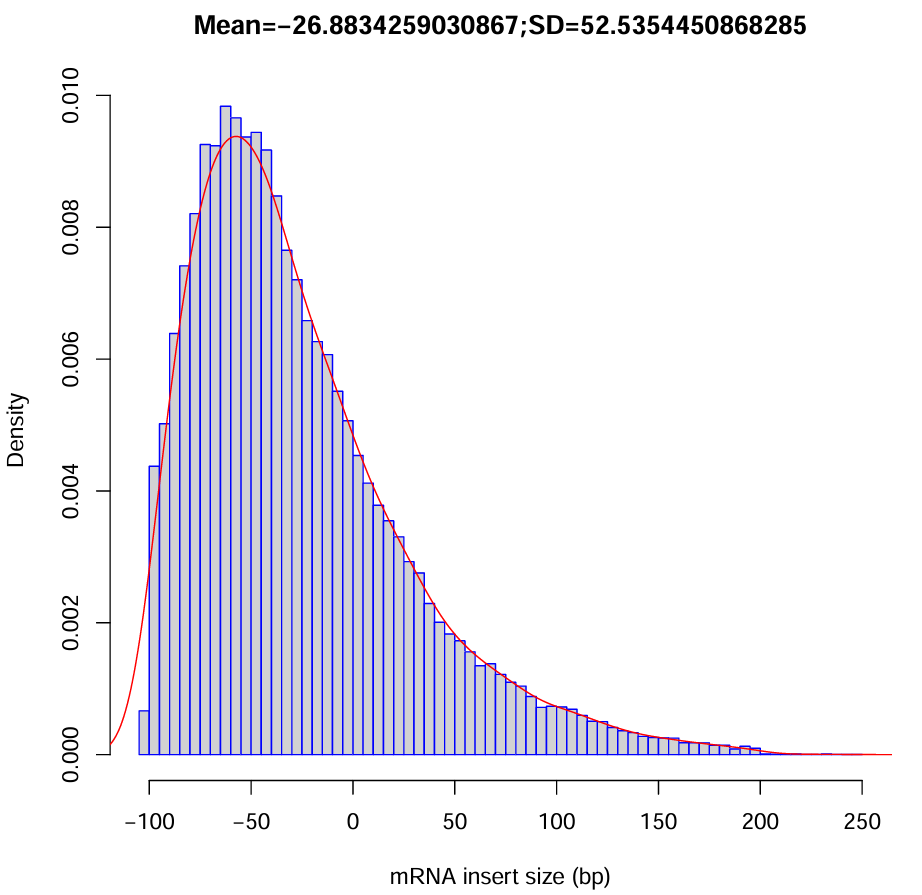

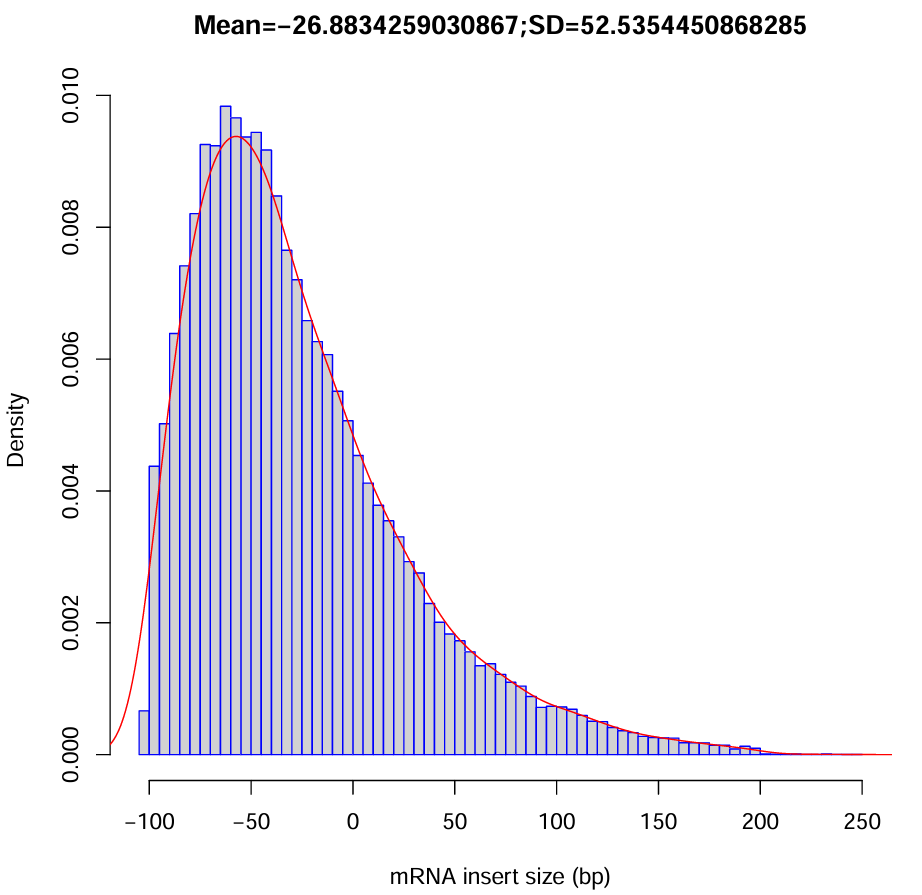

**📊 What the plot shows:**
- X-axis (mRNA insert size (bp)):
    - The "inner distance" between the paired-end reads, calculated based on spliced mRNA coordinates (i.e., after introns are removed).
    - Negative values: The paired reads overlap.
    - Zero: Reads are end-to-end.
    - Positive values: There is a gap (non-overlapping insert) between the reads.
- Y-axis (Density): The normalized frequency (probability density) of each insert size.

**🧠 How to interpret this right-skewed, negative-mean distribution:**
✅ Biological/technical explanation:
- Your sequencing library likely has short insert sizes, such that most of the paired-end reads overlap.
- This is **not uncommon in RNA-seq libraries made from fragmented or degraded RNA** (e.g., FFPE samples), or when the fragment size distribution skews toward the lower end.

**🔍 Why this matters:**
- Overlapping reads can affect quantification and aligner behavior (some tools may soft-clip or ignore the overlap).
- **Tools like htseq-count or featureCounts handle overlaps reasonably well if set correctly.**

### 2. Annotation of exon-exon junctions observed in RNA-seq alignments
View junction annotation of HBR_Rep1 at http://your-public-IPv4/rnaseq/alignments/hisat2/rseqc/HBR_Rep1.bam.splice_junction.pdf

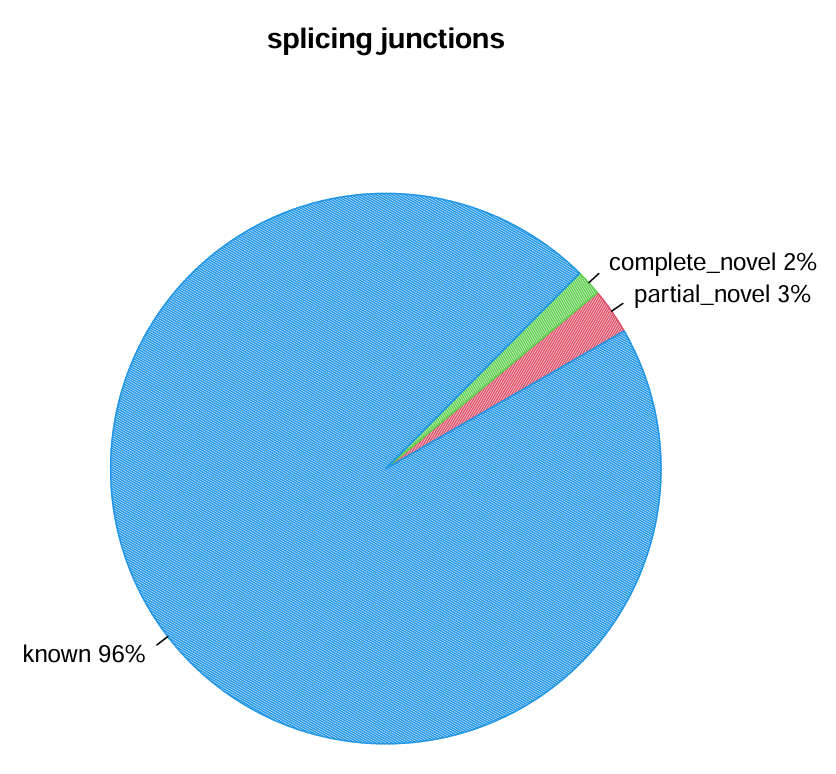

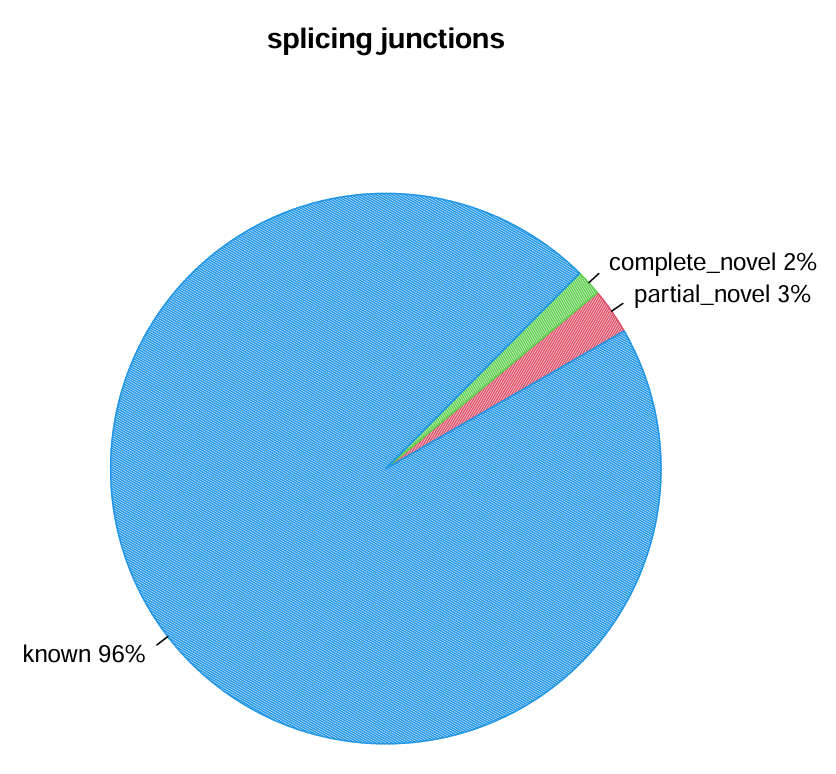

### 3. exon-exon junction saturation plot
View HBR_Rep1 junctionSaturation plot at: http://your-public-IPv4/rnaseq/alignments/hisat2/rseqc/HBR_Rep1.bam.junctionSaturation_plot.pdf

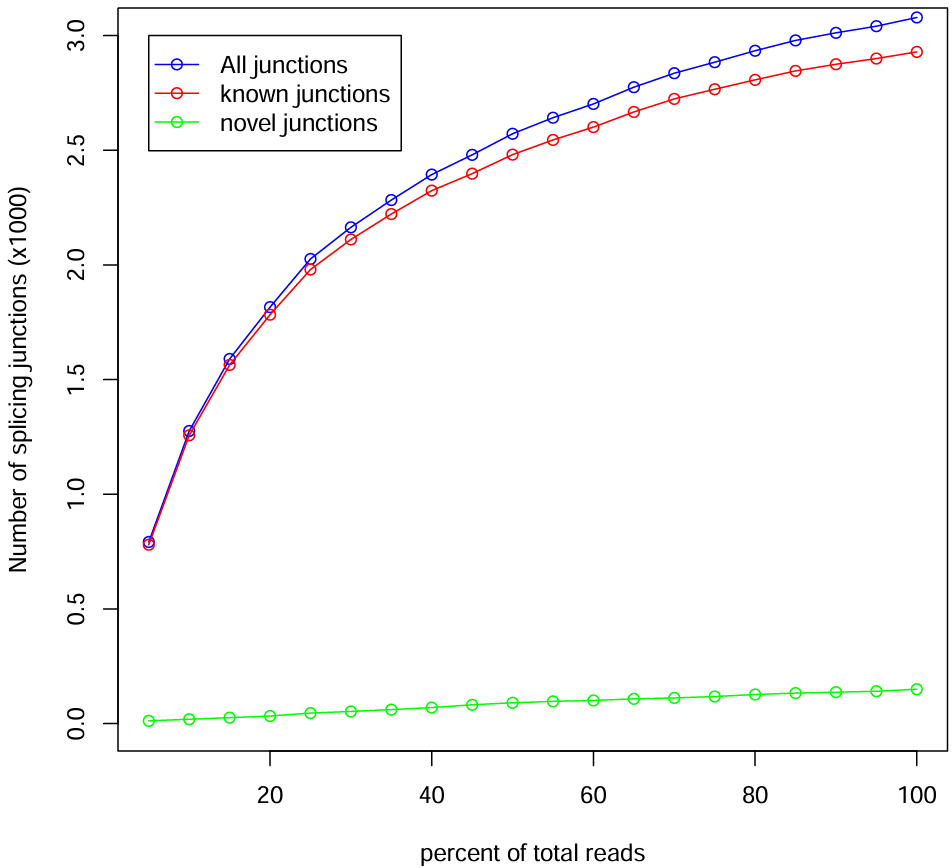

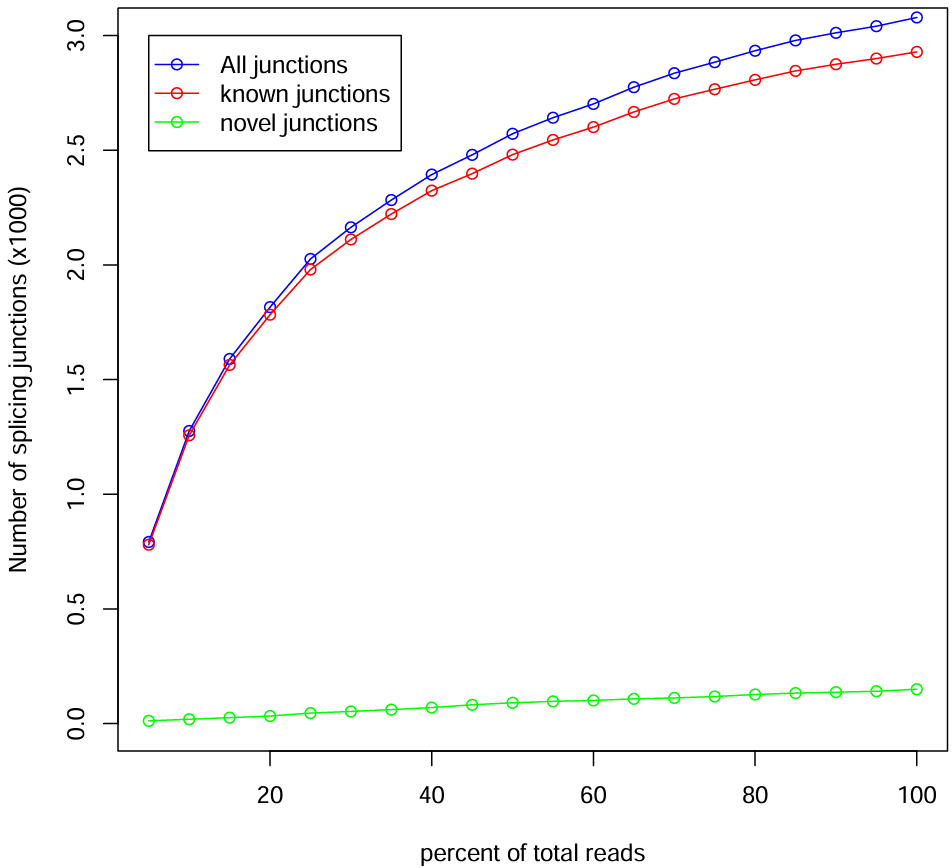

#### 🧬 What the Plot Shows:
- X-axis: Percent of total reads sampled (e.g., 5%, 10%, ..., 100%)
- Y-axis: Number of splicing junctions detected (×1000)

#### 🧠 Interpretation Tips:
- This plot tells you whether you're approaching saturation in detecting splice junctions. A flattening curve means you’ve captured most junctions, and deeper sequencing may not yield much more information.
- If the curve is still rising steeply at 100%, you might not have sequenced deeply enough to capture the full complexity.
- Compare known vs novel junctions: If novel junctions keep increasing, your sample might express unannotated transcripts (or there could be noise).

### 4. Read distribution
View read distribution for HBR_Rep1 at http://107.23.14.131/rnaseq/alignments/hisat2/rseqc/HBR_Rep1.bam.read_dist.txt
**Terminology breakdown:**

| Column           | Description                                                                                |
| ---------------- | ------------------------------------------------------------------------------------------ |
| **Total\_bases** | Total length (in bp) of all features in that category (e.g. total bases of all 5'UTRs).    |
| **Tag\_count**   | Number of **reads (tags)** that overlapped with this feature category.                     |
| **Tags/Kb**      | Number of tags per 1,000 bases in that category. A measure of **density** (like coverage). |

**📌 What does Tag_count mean?**
- Tag_count tells you how many reads aligned (even partially) to each genomic feature.
- One read = one tag. If a read spans multiple categories (e.g., a read starting in UTR and extending into CDS), RSeQC applies a priority hierarchy to assign it to only one. The hierarchy is same as the order of genomic feature: CDS > 5'UTR > 3'UTR > ...

**You can see that:**
- Most reads map to annotated exonic regions (CDS, 5'UTR, 3'UTR) — good!
    - A lot of reads map to 5′ UTRs — possibly over-represented or good coverage at transcript starts.
    - Lower read density at 3′ UTRs than 5′ UTRs or CDS. Could reflect sequencing bias or transcript structure. 
- Low intronic read counts suggest minimal pre-mRNA contamination.
- Very few reads mapping beyond transcription end sites (TES_down_1kb). Expected in clean RNA-seq.

| Group              | Total_bases        | Tag_count          | Tags/Kb |  
|--------------------| ------------------ | ------------------ | ------- |
| CDS_Exons          | 749425             | 64474              | 86.03   |          
| 5'UTR_Exons        | 1277689            | 120282             | 94.14   |         
| 3'UTR_Exons        | 1507472            | 31351              | 20.80   |        
| Introns            | 19799161           | 37771              | 1.91    |       
| TSS_up_1kb         | 706387             | 144                | 0.20    |      
| TSS_up_5kb         | 2910449            | 368                | 0.13    |         
| TSS_up_10kb        | 4821202            | 545                | 0.11    |         
| TES_down_1kb       | 793844             | 524                | 0.66    |         
| TES_down_5kb       | 3277515            | 1313               | 0.40    |         
| TES_down_10kb      | 5552856            | 1567               | 0.28    |         


### 6. Summarized mapping statistics of HBR_Rep1
View at http://your-public-IPv4/rnaseq/alignments/hisat2/rseqc/HBR_Rep1.bam.bam_stat.txt

#All numbers are READ count
| Category                                      | read count |
| --------------------------------------------- | ---------- |
| Total records:                                | 239400     |
| QC failed:                                    | 0          | 
| Optical/PCR duplicate:                        | 0          |
| Non primary hits                              | 2258       |
| Unmapped reads:                               | 188        |
| mapq < mapq_cut (non-unique):                 | 1455       |
| mapq >= mapq_cut (unique):                    | 235499     |
| Read-1:                                       | 117756     |
| Read-2:                                       | 117743     |
| **Reads map to '+':**                         | **117751** |
| **Reads map to '-':**                         | **117748** |
| Non-splice reads:                             | 213104     |
| **Splice reads:**                             | **22395**  |
| Reads mapped in proper pairs:                 | 234730     |
| Proper-paired reads map to different chrom:   | 0          |

**Some of these stats are shown in samtools flagstat (Total records, QC failed, etc), some are uniquely from RSeQC's bam_stat.py (Reads map to '+', Splice reads)**

In [13]:
samtools flagstat HBR_Rep1.bam

239400 + 0 in total (QC-passed reads + QC-failed reads)
237142 + 0 primary
2258 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
239212 + 0 mapped (99.92% : N/A)
236954 + 0 primary mapped (99.92% : N/A)
237142 + 0 paired in sequencing
118571 + 0 read1
118571 + 0 read2
236176 + 0 properly paired (99.59% : N/A)
236868 + 0 with itself and mate mapped
86 + 0 singletons (0.04% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


# 5. MultiQC
We will now use multiQC to compile a QC report from all the QC tools above.

In [14]:
cd $RNA_ALIGN_DIR
ls

HBR.bam           HBR_Rep2.sam      UHR_Rep1.bam.bai  UHR_Rep3.sam
HBR.bam.bai       HBR_Rep3.bam      UHR_Rep1.sam      fastqc
HBR_Rep1.bam      HBR_Rep3.bam.bai  UHR_Rep2.bam      flagstat
HBR_Rep1.bam.bai  HBR_Rep3.sam      UHR_Rep2.bam.bai  picard
HBR_Rep1.sam      UHR.bam           UHR_Rep2.sam      rseqc
HBR_Rep2.bam      UHR.bam.bai       UHR_Rep3.bam      samples.tsv
HBR_Rep2.bam.bai  UHR_Rep1.bam      UHR_Rep3.bam.bai


**multiqc .** recursively searches through the current directory and all subdirectories. automatically detects and parses log/output files from:
- FastQC (*_fastqc.zip, *_fastqc.html)
- Picard (*_metrics.txt, *_hs_metrics.txt, etc.)
- RSeQC (read_distribution.txt, junction_saturation_plot.pdf, etc.)

In [15]:
multiqc .


/// ]8;id=693758;https://multiqc.info\MultiQC]8;;\ 🔍 v1.28

       file_search | Search path: /workspace/rnaseq/alignments/hisat2
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 145/145  5 rseqc/HBR.geneBodyCoverage.heatMap.pdf
             rseqc | Found 6 read_distribution reports
             rseqc | Found 6 gene_body_coverage reports
             rseqc | Found 6 inner_distance reports
             rseqc | Found 6 junction_saturation reports
             rseqc | Found 6 bam_stat reports
        validation | picard/RnaSeqMetrics.py: warnings while parsing barplot.pconfig[id='picard_rnaseqmetrics_strand_plot'] {id: picard_rnaseqmetrics_strand_plot, title: Picard: RnaSeqMetrics Strand Mapping, ylab: Number of reads, hide_empty: False}:
• 'hide_empty': deprecated field. Use 'hide_zero_cats' instead
            picard | Found 6 RnaSeqMetrics reports
          samtools | Found 6 flagstat reports
            fastqc | Found 6 reports
     write_results | Data        :

View it at http://your-public-Ipv4/rnaseq/alignments/hisat2/multiqc_report.html

(not really helpful but) To view multiQC on QC reports from non-downsampled bam files: genomedata.org/rnaseq-tutorial/multiqc_report.html